In [256]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
import itertools

In [257]:
def stationarity_check(ts):
    # compute rolling statistics
    roll_mean = ts.rolling(window = 12).mean() # monthly stats, so window = 12

    # Plot rolling statistics:
    plt.plot(ts, color='green',label='Original')
    plt.plot(roll_mean, color='blue', label='Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean')
    plt.show(block=False)
    
    # Perform Augmented Dickey-Fuller test:
    print('Augmented Dickey-Fuller test:')
    df_test = adfuller(ts)
    print("df_test: ",df_test)
    df_output = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    print("df_output: \n",df_output)
    for key,value in df_test[4].items():
        df_output['Critical Value (%s)'%key] = value
    print(df_output)

In [258]:
df = pd.read_csv('climate-change-earth-surface-temperature-data/GlobalLandTemperaturesByCountry.csv')

In [259]:
df.head(10)

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
0,1743-11-01,4.384,2.294,Åland
1,1743-12-01,NaN,NaN,Åland
2,1744-01-01,NaN,NaN,Åland
3,1744-02-01,NaN,NaN,Åland
4,1744-03-01,NaN,NaN,Åland
5,1744-04-01,1.530,4.680,Åland
6,1744-05-01,6.702,1.789,Åland
7,1744-06-01,11.609,1.577,Åland
8,1744-07-01,15.342,1.410,Åland
9,1744-08-01,NaN,NaN,Åland


In [260]:
df.describe()

,AverageTemperature,AverageTemperatureUncertainty
count,544811.000000,545550.000000
mean,17.193354,1.019057
std,10.953966,1.201930
min,-37.658000,0.052000
25%,10.025000,0.323000
50%,20.901000,0.571000
75%,25.814000,1.206000
max,38.842000,15.003000


In [261]:
print(len(df.Country.unique()))

243


### Lets do temperature forecasting for country 'Nepal'

In [262]:
df_Nepal = df[df.Country == 'Nepal']
df_Nepal.index = pd.to_datetime(df_Nepal.dt)
df_Nepal = df_Nepal.loc['1970-01-01':]
df_Nepal = df_Nepal.drop('dt', axis = 1)
df_Nepal = df_Nepal.drop('AverageTemperatureUncertainty', axis = 1)
df_Nepal = df_Nepal.drop('Country', axis = 1)



In [263]:
df_Nepal.head(10)

,AverageTemperature
dt,
1970-01-01,6.072
1970-02-01,7.556
1970-03-01,12.401
1970-04-01,17.662
1970-05-01,20.572
1970-06-01,20.767
1970-07-01,20.901
1970-08-01,20.700
1970-09-01,19.708


In [264]:
# check if any value missing or not.
res = pd.isnull(df_Nepal.AverageTemperature.values)
res = res[res == True]
print(len(res))

1


In [265]:
# replacing missing average temperature from previous time stamp
df_Nepal = df_Nepal.sort_index()
df_Nepal.AverageTemperature.fillna(method='pad', inplace=True)

In [266]:
df_Nepal.describe()

,AverageTemperature
count,525.000000
mean,15.330236
std,5.526017
min,4.628000
25%,10.498000
50%,16.625000
75%,20.502000
max,23.440000


In [267]:
df_Nepal['ticks'] = range(0, len(df_Nepal.AverageTemperature.values))

In [268]:
df_Nepal.head(5)

,AverageTemperature,ticks
dt,,
1970-01-01,6.072,0
1970-02-01,7.556,1
1970-03-01,12.401,2
1970-04-01,17.662,3
1970-05-01,20.572,4


In [269]:
df_Nepal.tail(5)

,AverageTemperature,ticks
dt,,
2013-05-01,20.691,520
2013-06-01,21.375,521
2013-07-01,21.367,522
2013-08-01,21.185,523
2013-09-01,21.185,524


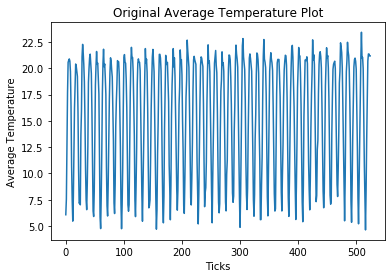

In [270]:
# basic plot of the average temperature.
fig = plt.figure(1)
ax1 = fig.add_subplot(111)
ax1.set_xlabel('Ticks')
ax1.set_ylabel('Average Temperature')
ax1.set_title('Original Average Temperature Plot')
ax1.plot('ticks', 'AverageTemperature', data = df_Nepal)

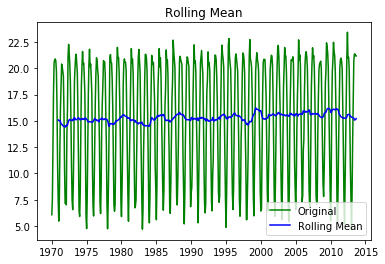

Augmented Dickey-Fuller test:
df_test:  (-4.1377997576435375, 0.0008381920409154401, 15, 509, {'1%': -3.443262740636999, '5%': -2.8672350350046787, '10%': -2.569803239025633}, 1315.5349742899252)
df_output: 
 Test Statistic                  -4.137800
p-value                          0.000838
#Lags Used                      15.000000
Number of Observations Used    509.000000
dtype: float64
Test Statistic                  -4.137800
p-value                          0.000838
#Lags Used                      15.000000
Number of Observations Used    509.000000
Critical Value (1%)             -3.443263
Critical Value (5%)             -2.867235
Critical Value (10%)            -2.569803
dtype: float64


In [271]:
# check if the average temperature data follows stationary distribution or not.
stationarity_check(df_Nepal.AverageTemperature)

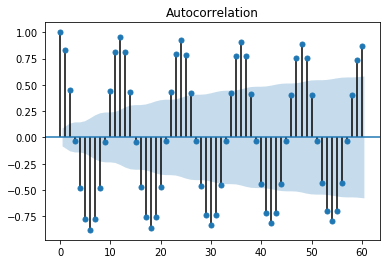

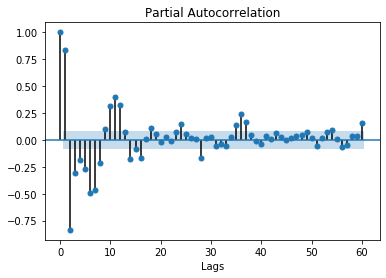

In [272]:
plot_acf(df_Nepal.AverageTemperature, lags=60)
plot_pacf(df_Nepal.AverageTemperature, lags=60)
plt.xlabel('Lags')
plt.show()

In [273]:
# Generating permutation of p and q for ARMA model.
# Choose the model with low AIC.
p = q = range(0, 4)
pq = itertools.product(p, q)

for param in pq:
    try:
        mod = ARMA(df_Nepal.AverageTemperature, order=param)
        results = mod.fit()
        print('ARMA{} - AIC:{}'.format(param, results.aic))
    except:
        continue

/Users/prakash/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARMA(0, 0) - AIC:3287.825128979732
ARMA(0, 1) - AIC:2743.0111504643737
ARMA(1, 0) - AIC:2655.1155431539773
ARMA(1, 1) - AIC:2367.2633394280765
ARMA(1, 2) - AIC:2733.333802613277
ARMA(1, 3) - AIC:2435.2131465352886
ARMA(2, 0) - AIC:2010.175200071902
ARMA(2, 2) - AIC:1844.6580364916113


/Users/prakash/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARMA(2, 3) - AIC:1691.0843221120356
ARMA(3, 0) - AIC:1961.2899657982434
ARMA(3, 2) - AIC:1753.438115084933
ARMA(3, 3) - AIC:1685.7914493769472


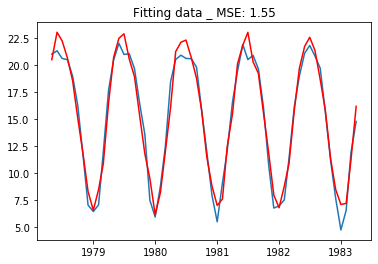

In [275]:
# Build an ARMA model and plot the original and fitted average temperatures.
model = ARMA(df_Nepal.AverageTemperature, order=(3,3))  
results_MA = model.fit()  
plt.plot(df_Nepal.AverageTemperature[100:160])
plt.plot(results_MA.fittedvalues[100:160], color='red')
plt.title('Fitting data _ MSE: %.2f'% (((results_MA.fittedvalues-df_Nepal.AverageTemperature)**2).mean()))
plt.show()

In [276]:
# future predictions for date 2010-to-2023
preds = results_MA.predict('01/01/2010', '12/01/2023')

orig = df_Nepal.loc['01/01/2010':]
orig = orig.drop('ticks', axis = 1)

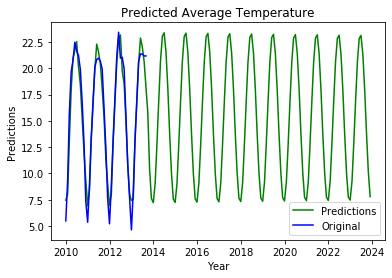

In [277]:
plt.plot(preds, color='green',label='Predictions')
plt.plot(orig, color='blue', label = 'Original')
# plt.plot(roll_mean, color='blue', label='Rolling Mean')
plt.legend(loc='best')
plt.xlabel('Year')
plt.ylabel('Predictions')
plt.title('Predicted Average Temperature')
plt.show(block=False)

In [286]:
df_pred = pd.DataFrame()
df_pred['Year-Month'] = preds['01/01/2023':].index.values
df_pred['Average Temperature (C)'] = preds['01/01/2023':].values
print(df_pred.to_string(index=False))

Year-Month  Average Temperature (C)
2023-01-01                 7.464991
2023-02-01                 9.266314
2023-03-01                12.684900
2023-04-01                16.803886
2023-05-01                20.519270
2023-06-01                22.835816
2023-07-01                23.133644
2023-08-01                21.334104
2023-09-01                17.920542
2023-10-01                13.808474
2023-11-01                10.100046
2023-12-01                 7.788632
